
# Analysis of no-show appointments dataset


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction



#### This dataset includes over 110k medical appointments of a hospital in Brazil. The dataset includes 14 variables and if the patient showed up to the appointment (show) or did not (no show). 

 The variable include:
01. PatientId
>Identification of a patient; duplication occurs in cases where the same patient booked more than one appointment.
02. AppointmentID
>Identification of each appointment. (must be unique)
03. Gender
>Male or Female .
04. ScheduledDay:
>indicates the Date/Time the patient set up their appointment.
05. AppointmentDay
>The date someone booked the appointment.
06. Age
>How old is the patient.
07. Neighbourhood
>Where the appointment takes place.
08. Scholarship
>indicates whether or not the patient is enrolled in the brazilian welfare program.
09. Hipertension
>Whether or not the patient has Hypertension.
10. Diabetes
>indicates whether or not the patient has Diabetes.
11. Alcoholism
>indicates whether or not the patient suffers from Alcoholism
12. Handcap
>indicates whether or not the patient is with special needs.
13. SMS_received
>indicates whether or not the patient has received a reminder text message.
14. No-show
>‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up. This is the dependent variable, the rest above are independent variables.



### The question I would like to analyze include: 


##### -Are younger people more/less likely to miss appointments compared to older patients?

##### -How do diseases/disorders like hypertension, diabetes, alcoholism or being handicapped affect if the patient is a no-show?

##### -Do preventable measures applied by health facilities (like sending SMS messages as reminders) help in reducing the number of no-shows?


In [1]:
#import libraries 
import pandas as pd
import numpy as np
import datetime
from time import strftime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


In [2]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling


### General Properties


In [3]:
# Load data
df = pd.read_csv('Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv')
df.shape


(110527, 14)

In [4]:
#Print info about the dataset
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### The cell above shows there is no missing values. 
#### Next, I want to check for data format and datatypes (quantitative/categorical). I use the pairplot function from seaborn library which allows to plot pair-wise relationships between variables in a dataset. 


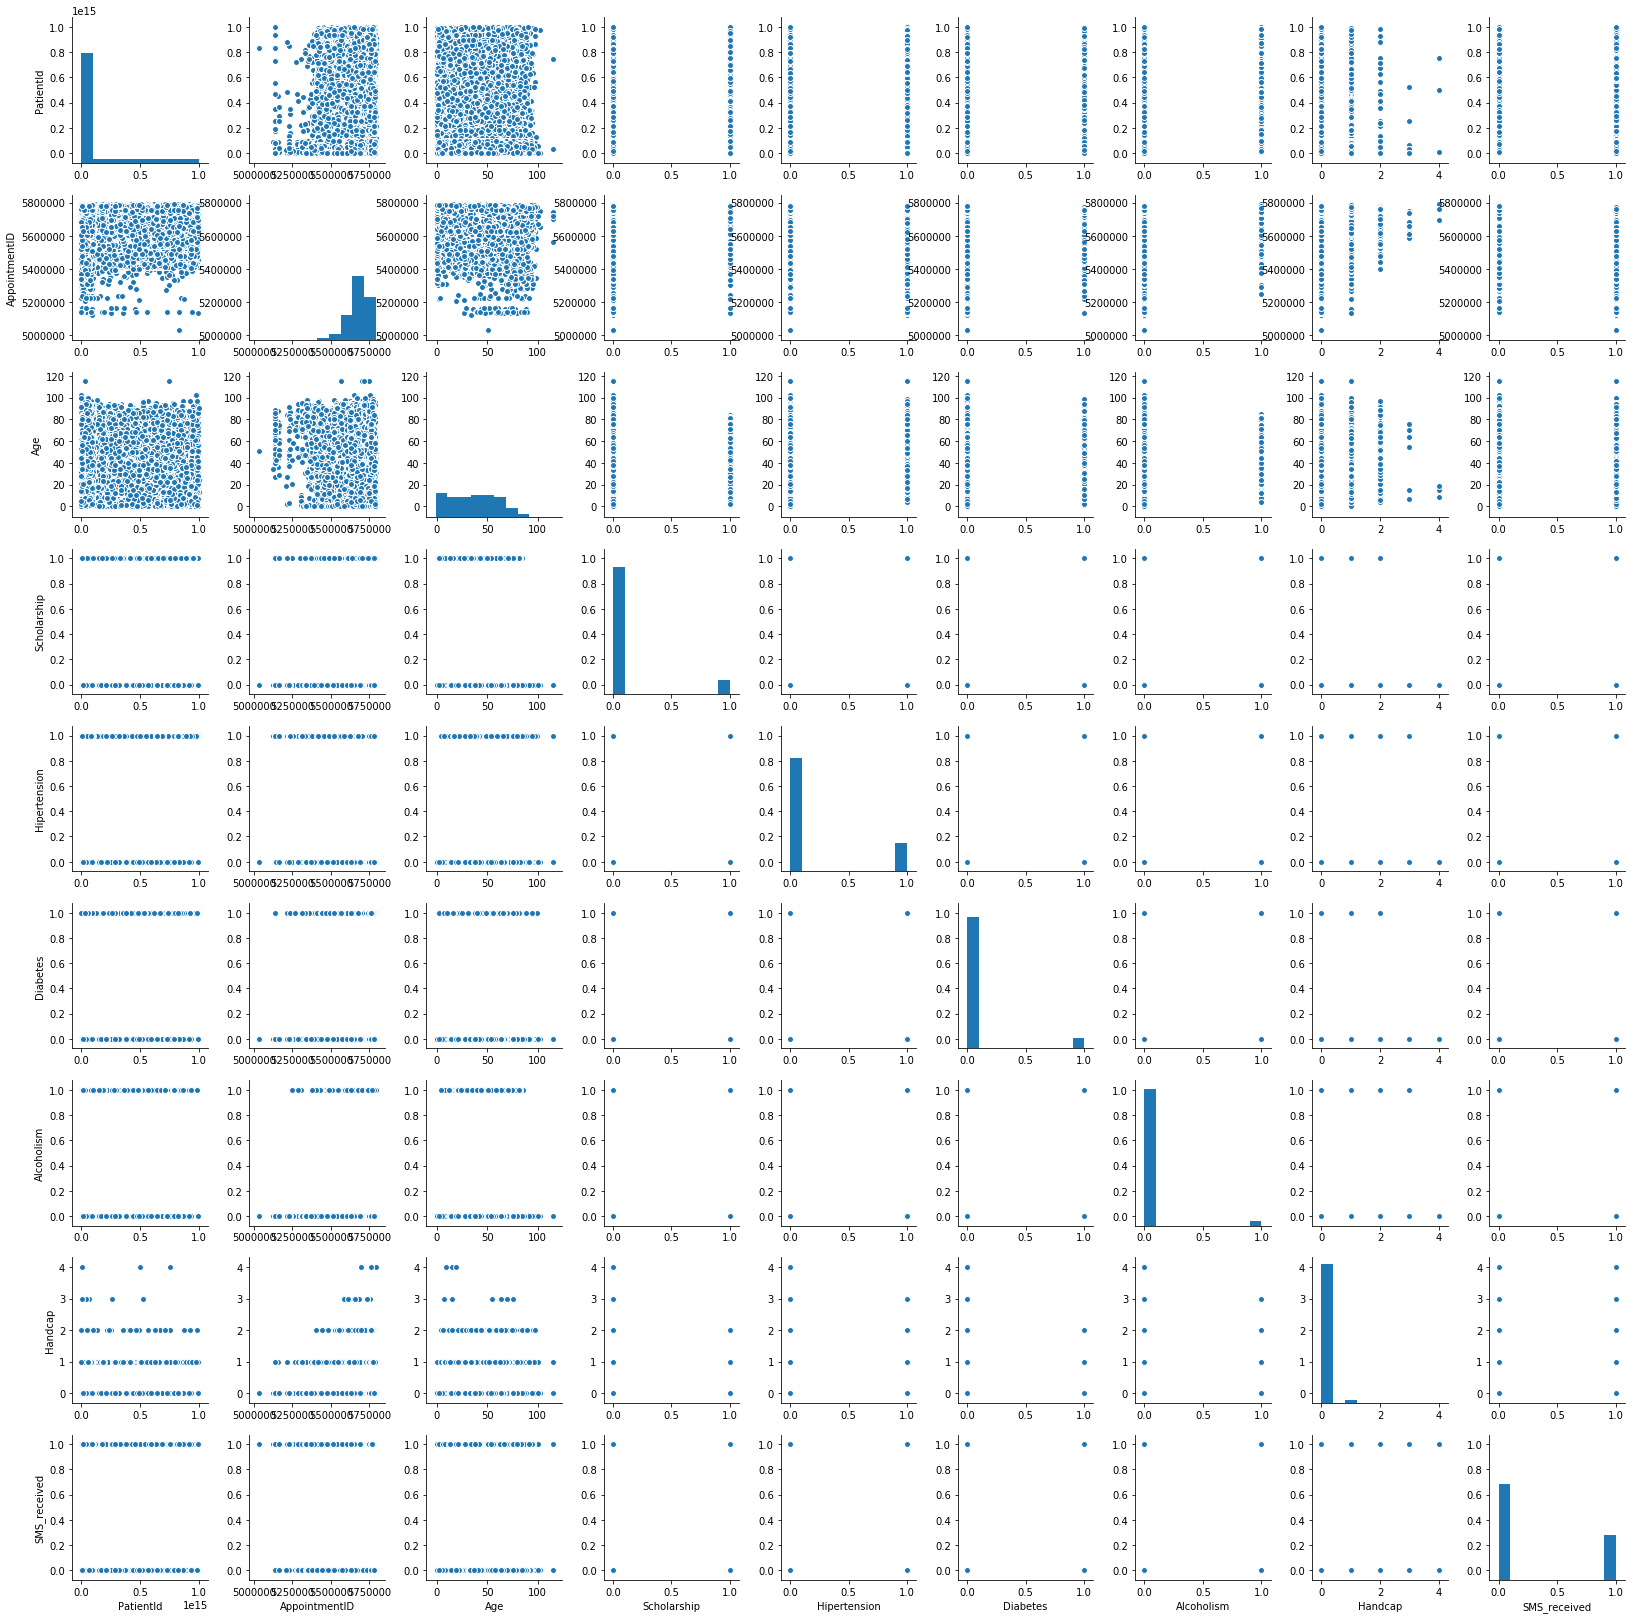

In [5]:
sns.pairplot(df);


#### Looking at the figure above, we can tell which variables belong to which type:

#### Categorical variables: Gender, Scholarship, Diabetes, Alcoholism, Handcap, SMS_received, No-show
#### Quantitative variables: PatientId, AppointmentID, Age, ScheduledDay, AppointmentDay

#### To explore more about specific datatypes, I use the .unique() function from pandas to check for unique values for each (Categorical variable) column in the dataset to determine if it has the appropriate type.


In [5]:
# Print Unique Values
print("Unique values in `Gender` {}".format(df.Gender.unique()))
print("Unique values in `Scholarship` {}".format(df.Scholarship.unique()))
print("Unique values in `Hipertension` {}".format(df.Hipertension.unique()))
print("Unique values in `Diabetes` {}".format(df.Diabetes.unique()))
print("Unique values in `Alcoholism` {}".format(df.Alcoholism.unique()))
print("Unique values in `Handcap` {}".format(df.Handcap.unique()))
print("Unique values in `SMS_received` {}".format(df.SMS_received.unique()))

Unique values in `Gender` ['F' 'M']
Unique values in `Scholarship` [0 1]
Unique values in `Hipertension` [1 0]
Unique values in `Diabetes` [0 1]
Unique values in `Alcoholism` [0 1]
Unique values in `Handcap` [0 1 2 3 4]
Unique values in `SMS_received` [0 1]


#### All of the variables listed above (excluding Handcap) are binary variables.
#### I will deal with datatypes in the next section

In [5]:
#Check correlation between variables
df.corr().style.background_gradient(cmap='Greens')

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
PatientId,1,0.00403857,-0.0041394,-0.00288023,-0.00644107,0.00160532,0.0110115,-0.00791605,-0.00974946
AppointmentID,0.00403857,1,-0.0191265,0.0226149,0.0127522,0.0226283,0.0329439,0.0141056,-0.256618
Age,-0.0041394,-0.0191265,1,-0.0924572,0.504586,0.292391,0.0958113,0.0780332,0.0126434
Scholarship,-0.00288023,0.0226149,-0.0924572,1,-0.0197288,-0.0248935,0.0350225,-0.00858628,0.00119401
Hipertension,-0.00644107,0.0127522,0.504586,-0.0197288,1,0.433086,0.0879708,0.0800833,-0.00626686
Diabetes,0.00160532,0.0226283,0.292391,-0.0248935,0.433086,1,0.0184735,0.05753,-0.01455
Alcoholism,0.0110115,0.0329439,0.0958113,0.0350225,0.0879708,0.0184735,1,0.00464765,-0.0261474
Handcap,-0.00791605,0.0141056,0.0780332,-0.00858628,0.0800833,0.05753,0.00464765,1,-0.0241609
SMS_received,-0.00974946,-0.256618,0.0126434,0.00119401,-0.00626686,-0.01455,-0.0261474,-0.0241609,1


##### the highest correlation is between hypertension and age, hypertension and diabetes, and diabetes and age, which makes sense because people are more likely to get them as they get older.

### Data Cleaning


#### For this step, there are a few obvious things that need correction, like the typos in column names, and a couple of not so obvious ones. The list below describes all the steps I plan on taking. 

1. Correction of typos in variable names.
2. Checking for duplicated rows and/or NaNs in the data. 
3. Correction of data types:
       -PatientId is a Float, i will convert it to String since it has no numerical value.
       -ScheduledDay and AppointmentDay will be converted to DateTime, I will also remove the 
         timestamp since it has no use (it is listed as 00:00:00 in every row). 

4. Deletion of variables that add **no information** to the analysis. 
5. Check the range of unique values to make sure there were no data collection mistakes. 



In [6]:
#Step 1
#Renaming columns with vauge names/typos

df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [7]:
#Step 2
# Check for duplicate rows 
df.duplicated().sum()

0

#### No duplicates in the dataset

In [8]:
#Step 3: Correction of data types

# Convert PatientId from Float to string 
df['PatientId'] = df['PatientId'].astype('str')

# Convert ScheduledDay and AppointmentDay from 'object' type to 'datetime'
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]') 


Below, we will drop 'PatientId' and 'AppointmentID' from the dataframe as they are just some system genrated numbers.

In [9]:
#Step 4: remove variables that add no information 

#Dropping 'PatientId' and 'AppointmentID' as they are just some system 
# genrated numbers.
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [10]:
#Step 5: Check the range of unique values (in quantitative variables) 
# to make sure there were no data collection mistakes. 

# Print Unique Values for 'Age'
print("Unique Values in `Age` => {}".format(np.sort(df.Age.unique())))

Unique Values in `Age` => [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 102 115]


#### there is clearly an error with sample(s) that were recorded as having an age = -1
#### checcking how many of these samples there are 

In [11]:
print("Patients with `Age` less than 0: {}".format(df[df.Age < 0].shape[0]))

Patients with `Age` less than 0: 1



#### As there is only one patient with Age < 0, I choose to delete that record assuming that it was just a typo that happened during data collection.

In [12]:
#delete the sample with age < 0
df = df[df.Age >= 0]


#### create a new "age_group" variable to represent the Age variable for better visualization in the upcoming section

In [13]:
# Define a new column to include the Age Groups

AgeGroupLabels = [ "{0} - {1}".format(i, i + 19) for i in range(0, 120, 20)]
df['AgeGroup'] = pd.cut(df.Age, range(0, 121, 20), right=False, labels=AgeGroupLabels)
df['AgeGroup'] = df.AgeGroup.astype('category')
df.AgeGroup.cat.categories

Index(['0 - 19', '20 - 39', '40 - 59', '60 - 79', '80 - 99', '100 - 119'], dtype='object')

#### The cell above shows 6 Age groups (in years) ranging from 0 - 119 with an internal of 20 years

In [15]:

# Print Unique Values for 'ScheduledDay'
print("Unique Values in `ScheduledDay`: {}".format(np.sort(df.ScheduledDay.dt.strftime('%Y-%m-%d').unique())))

Unique Values in `ScheduledDay`: ['2015-11-10' '2015-12-03' '2015-12-07' '2015-12-08' '2015-12-14'
 '2015-12-15' '2016-01-04' '2016-01-05' '2016-01-07' '2016-01-11'
 '2016-01-13' '2016-01-14' '2016-01-19' '2016-01-20' '2016-01-21'
 '2016-01-22' '2016-01-25' '2016-01-26' '2016-01-27' '2016-01-28'
 '2016-01-29' '2016-02-01' '2016-02-02' '2016-02-03' '2016-02-04'
 '2016-02-05' '2016-02-11' '2016-02-12' '2016-02-15' '2016-02-16'
 '2016-02-17' '2016-02-18' '2016-02-19' '2016-02-22' '2016-02-23'
 '2016-02-24' '2016-02-25' '2016-02-26' '2016-02-29' '2016-03-01'
 '2016-03-02' '2016-03-03' '2016-03-04' '2016-03-05' '2016-03-07'
 '2016-03-08' '2016-03-09' '2016-03-10' '2016-03-11' '2016-03-14'
 '2016-03-15' '2016-03-16' '2016-03-17' '2016-03-18' '2016-03-19'
 '2016-03-21' '2016-03-22' '2016-03-23' '2016-03-28' '2016-03-29'
 '2016-03-30' '2016-03-31' '2016-04-01' '2016-04-05' '2016-04-06'
 '2016-04-07' '2016-04-08' '2016-04-09' '2016-04-11' '2016-04-12'
 '2016-04-13' '2016-04-14' '2016-04-15' '20

the output above shows that the ScheduledDay variable for appointments is ranging from 2015-11-10 to 2016-06-08, which is around 7 months of data.

In [16]:
# Print Unique Values for 'AppointmentDay'
print("Unique Values in `AppointmentDay`: {}".format(np.sort(df.AppointmentDay.dt.strftime('%Y-%m-%d').unique())))

Unique Values in `AppointmentDay`: ['2016-04-29' '2016-05-02' '2016-05-03' '2016-05-04' '2016-05-05'
 '2016-05-06' '2016-05-09' '2016-05-10' '2016-05-11' '2016-05-12'
 '2016-05-13' '2016-05-14' '2016-05-16' '2016-05-17' '2016-05-18'
 '2016-05-19' '2016-05-20' '2016-05-24' '2016-05-25' '2016-05-30'
 '2016-05-31' '2016-06-01' '2016-06-02' '2016-06-03' '2016-06-06'
 '2016-06-07' '2016-06-08']


the output above shows that AppointmentDay ranges from 2016-04-29 to 2016-06-08. The AppointmentDay spans just above 1 Month.

In [17]:
print("NoShow and Show Count of Patients\n")
print(df.groupby(['NoShow']).size())

print("\nNoShow and Show '%' of Patients\n")
show = df.groupby(['NoShow']).size()[0]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who `Showed Up` => {:.2f}%".format(show*100))
noshow = df.groupby(['NoShow']).size()[1]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who Did `Not Showed Up` => {:.2f}%".format(noshow*100))

NoShow and Show Count of Patients

NoShow
No     88207
Yes    22319
dtype: int64

NoShow and Show '%' of Patients

Percent of Patients who `Showed Up` => 79.81%
Percent of Patients who Did `Not Showed Up` => 20.19%


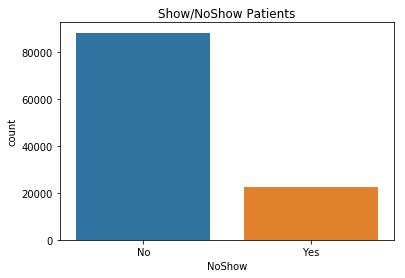

In [18]:
ax = sns.countplot(x=df.NoShow, data=df)
ax.set_title("Show/NoShow Patients")
plt.show()

#### The figure above shows that for the majority of appointments booked, the paitent does show up. Around 80% of the patients are coming for the visit after an appointment while around 20% are skipping their appointments.

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1: Does age affect if a patient is a show/no show?


I will draw a boxplot for the Age feature to check its distribution.



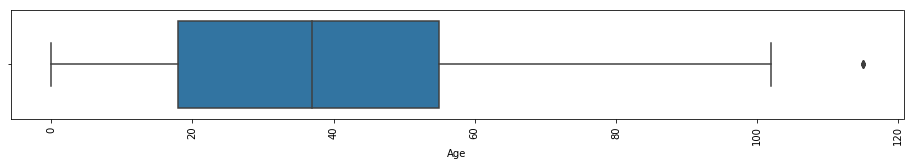

In [19]:
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
_ = sns.boxplot(x=df.Age)

From the above BoxPlot we can see that the Median Age is around 30 and the IQR is between 18 and 55. Though the BoxPlot shows few datapoints as outliers we will not consider them as true outliers for this case.

Below we will plot the number of patients for different Age groups.

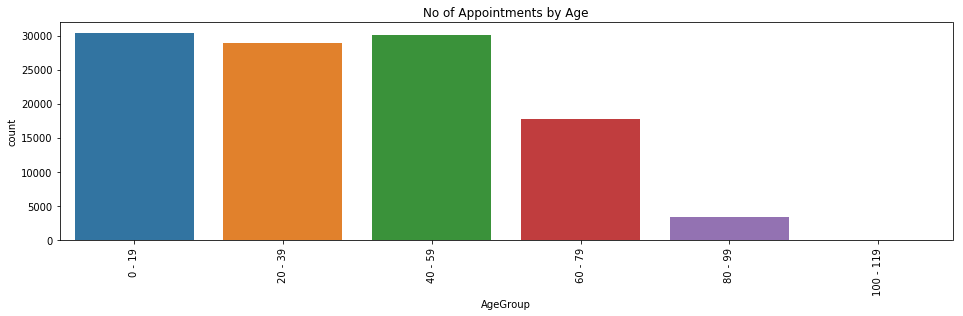

In [20]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.AgeGroup)
ax.set_title("No of Appointments by Age")
plt.show()

From the above histogram, we can see that the number of appointments for patients from ages 0 - 59 are similar but they start to decline after that, which is most likely because there is just a lesser number of people that old in this population.  

Below we will plot the Show/NoShow for the patients based on their age group.

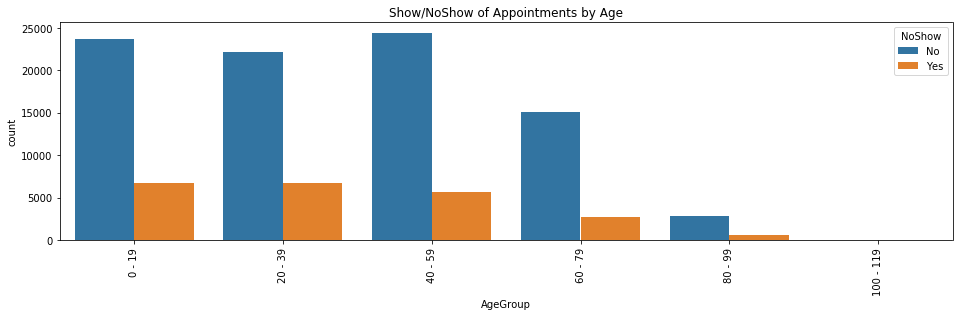

In [21]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.AgeGroup, hue=df.NoShow)
ax.set_title("Show/NoShow of Appointments by Age")
plt.show()

From the above visualization it looks like the ratio of Show vs. NoShow is quite similar. I will use another figure to get the ratio of Show vs. NoShow for different age groups.

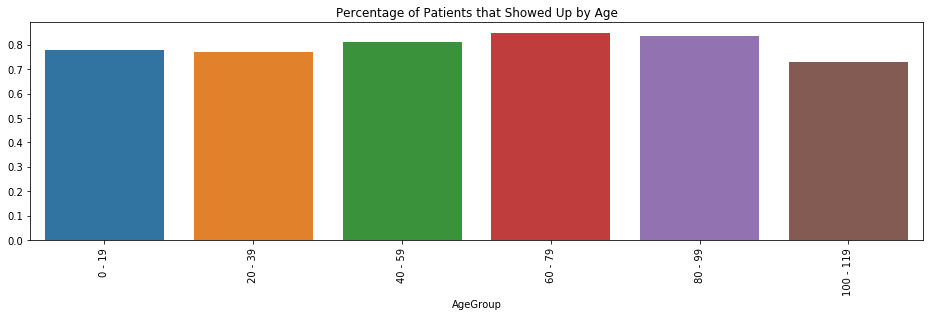

In [23]:
df_age_ratio = df[df.NoShow == 'No'].groupby(['AgeGroup']).size()/df.groupby(['AgeGroup']).size()

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x=df_age_ratio.index, y=df_age_ratio)
ax.set_title("Percentage of Patients that Showed Up by Age")
plt.show()

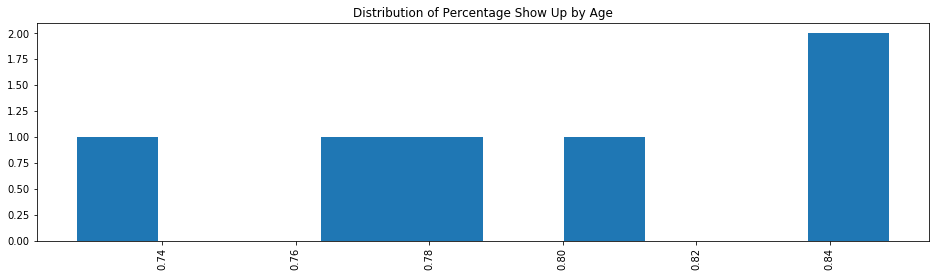

In [24]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = plt.hist(df_age_ratio)
plt.title("Distribution of Percentage Show Up by Age")
plt.show()

From the above visualization we could clearly see that all age groups patients have around 0.74-85% Show rate. The analysis shows that age **is not** a factor in determining if a patient is a show/no-show

### Research Question 2: How do diseases/disorders like hypertension, diabetes, or alcoholism affect if the patient is a no-show?

#### Starting with Alcoholism, I will check how it affects the show vs. NoShow outcome

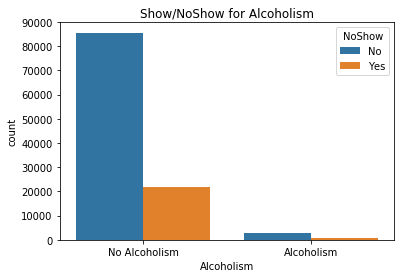

In [25]:
ax = sns.countplot(x=df.Alcoholism, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.show()

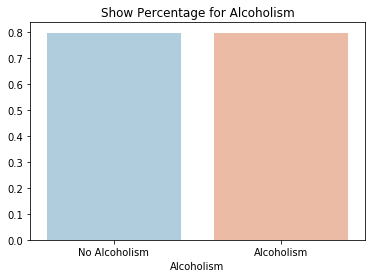

In [26]:
df_a_ratio = df[df.NoShow == 'No'].groupby(['Alcoholism']).size()/df.groupby(['Alcoholism']).size()
ax = sns.barplot(x=df_a_ratio.index, y=df_a_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.show()

From the figures above, out of all 11500 patients, 5,500 of them have Alcoholism. And out of these 5500 around 80% of them have come for the visit.

There are around 105,000 patients that do not suffer from Alcoholism and out of them also around 80% have come for the visit.

This shows us that alcoholism is not a good indication in determining whether a patient will show up or not in this dataset. 


#### Next, I will check how Hypertension might affect the show vs. NoShow outcome

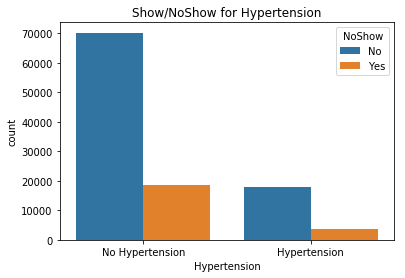

In [14]:
ax = sns.countplot(x=df.Hypertension, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.show()

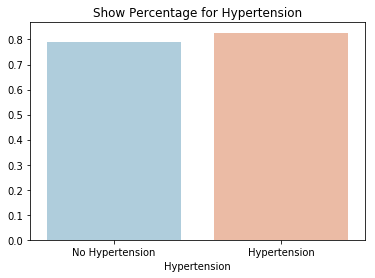

In [15]:
df_h_ratio = df[df.NoShow == 'No'].groupby(['Hypertension']).size()/df.groupby(['Hypertension']).size()
ax = sns.barplot(x=df_h_ratio.index, y=df_h_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.show()

The figures show that 85% of patients with Hypertension show up to their appointments, while only 78% of patients that do not have Hypertension show up. This means that Hypertension could help us in determining if a patient will show up to their appointment.

#### Next, I will check how Diabetes might affect the show vs. NoShow outcome

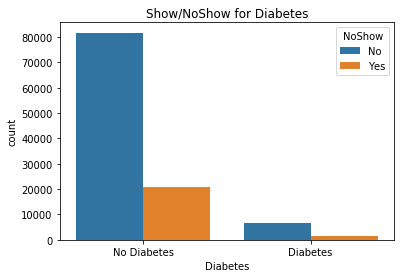

In [16]:
ax = sns.countplot(x=df.Diabetes, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
plt.show()

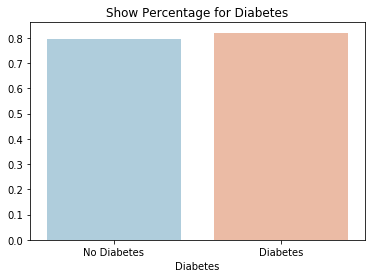

In [17]:
df_d_ratio = df[df.NoShow == 'No'].groupby(['Diabetes']).size()/df.groupby(['Diabetes']).size()
ax = sns.barplot(x=df_d_ratio.index, y=df_d_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
plt.show()


The figures show that there are 8,500 patients with Diabetes around 83% of them have come for the visit. While the rest of the 102,000 patients that do not have the disease, around 80% have come for the visit. This means that Diabetes could help us in determining if a patient will show up to their appointment, but to a lesser extent compared to Hypertension variables.

### Research Question 3: Do preventable measures applied by health facilities (like sending SMS messages as reminders) help in reducing the number of no-shows?

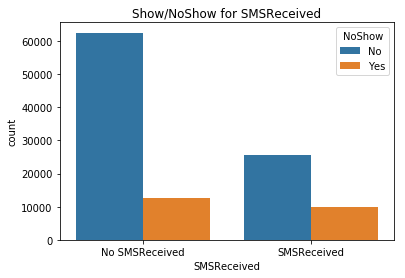

In [17]:
ax = sns.countplot(x=df.SMSReceived, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()

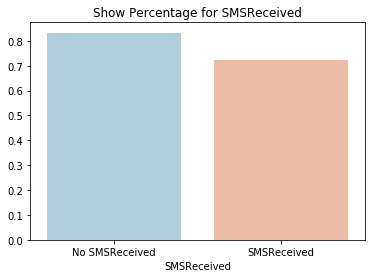

In [40]:
df_s_ratio = df[df.NoShow == 'No'].groupby(['SMSReceived']).size()/df.groupby(['SMSReceived']).size()
ax = sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()

The figures show that there are 75,000 patients who have not received SMS and out of them around 84% have come for the visit. While the rest of the 35,500 patients who have received SMS around 72% of them have come for the visit. This means that SMS reminders (somewhat) have the opposite effect, as patients who do not receive them are more likely to show up compared to those who receive them. 

<a id='conclusions'></a>
## Conclusions


In this analysis, the goal was to investigate a dataset from a brazilian hospital that includes 110k records of appointments. While the records proved helpful in figuring out why appointments were missed in this particular population, there were some limitations: 

- The AppointmentDay variable spans just over a month, which means that the dataset represents only a snapshot of the complete data, analyzing a small part of the data is difficult and might not make a proper representation of the full data.


- AppointmentDay and ScheduledDay missed adding the exact time the booking was made, this information could have been helpful in the analysis of the outcome.

- While the data included interesting variables, like alcoholism and other disorders, many other variables would have been interesting to investigate as well, like mental illnesses and employment status, or the specialization of the doctor.

Questions I stated in the beginning to investigate further included:  

##### -Are younger people more/less likely to miss appointments compared to older patients?

All age groups patients had similar show up rate. The analysis shows that age **is not** a factor in determining if a patient is a show/no-show

##### -How do diseases/disorders like hypertension, diabetes, or alcoholism affect if the patient is a no-show?

The analysis showed that rate of show vs. no-show of alcoholics vs non-alcoholics was the same, so alcoholism does not affect if a patient will show up to an appointment or not. This was not the case for hypertension and diabetes, as the analysis showed that pateints with either of those diseases have lower no-show up rate than those without the diseases.

##### -Do preventable measures applied by health facilities (like sending SMS messages as reminders) help in reducing the number of no-shows?

No, sending an SMS seems to somehow have the opposite effect in reducing no-show rates. The analysis showed that patients that receive SMS reminders have a 12% lower show up rate. This could be due to how soon/late the SMS are sent.


In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0